In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import colorsys
import os
import cv2
import pathlib
from matplotlib import cm
from matplotlib import colors
from math import copysign, log10
import mahotas
%matplotlib inline

## Collecting the image paths from the folder

In [5]:
eyes = pathlib.Path("C:\\Users\\mehul\\Desktop\\Assignment\\Cat-Eye-Extraction-and-Classification\\Cat Eyes Data - Resized\\left eyes")

eye_files = [x for x in eyes.glob('*.jpg')]
print(f'{len(eye_files)} Images retrieved')

5782 Images retrieved


## Calculating HSV histogram 

In [6]:
def histogram(img):
    hist = cv2.calcHist([img], [0,1,2], None, [100,100,10], [-1,1,-1,1,0,1])
    hist = hist.flatten()
    return(hist)

## Calculating HU Moments and Haralicks as Features Descriptors

In [7]:
def fd_hu_moments(path):
    gray = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    huMoments = cv2.HuMoments(cv2.moments(gray)).flatten()
    #bringing all the moments to the same scale
    for i in range(0,7):
      huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))
    return huMoments
def fd_haralick(path):    # convert the image to grayscale
    gray = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    #print(len(haralick))
    return haralick

## Calculating Polar HSV Histogram and combining the above Feature Descriptors

In [8]:
def feature_extractor_hsv_polar(paths):
    global_features = []
    for j in range(len(paths)):
        im = Image.open(paths[j])
        w,h = im.size
        colors = im.getcolors(w*h)
        h,v,s = [],[],[]
        for i in range(len(colors)):
            colors[i] = list(colors[i])
            colors[i][1] = colorsys.rgb_to_hsv(r=colors[i][1][0]/255, g=colors[i][1][1]/255, b=colors[i][1][2]/255)
            colors[i][1] = (colors[i][1][0]*np.sin(colors[0][1][1]*2*np.pi),colors[i][1][0]*np.cos(colors[0][1][1]*2*np.pi),colors[i][1][2])
            h.extend([colors[i][1][0]]*colors[i][0])
            s.extend([colors[i][1][1]]*colors[i][0])
            v.extend([colors[i][1][2]]*colors[i][0])
        x,_ = np.histogram(h,50,(0,1.0))
        y,_ = np.histogram(s,50,(0,1.0))
        z,_ = np.histogram(v,50,(0.,1.0))
        m = np.hstack([x,y,z])
        global_feature = np.hstack([m, fd_haralick(paths[j]), fd_hu_moments(paths[j])])
        global_features.append(global_feature)
      
    return(np.vstack(global_features))

In [9]:
histograms_hsv = feature_extractor_hsv_polar(eye_files)
len(histograms_hsv)

5782

In [10]:
np.save('hsv_polar_fd',histograms_hsv)

## Utility functions to print an array of images

In [19]:
def img_plot(imgs):
    if(type(imgs) is list):
        f, axarr = plt.subplots(1,len(imgs),figsize=(15, 15))
        for i,img in enumerate(imgs):
                #print(img)
                img = cv2.imread(str(img))
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axarr[i].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
                axarr[i].axis('off')
            #plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
                
        plt.show()
    else: 
        plt.imshow(cv2.cvtColor(imgs,cv2.COLOR_BGR2RGB))
        plt.show()
def plot_array(num_samples,imgs):
    if(num_samples>len(imgs)):
        num_samples = len(imgs)
    np.random.seed = 10
    sample = np.random.randint(0,len(imgs),num_samples)
    rows = -(-num_samples//10)
    for i in range(0,num_samples,10):
        temp = sample[i:i+10]
        arr = []
        for x in temp:
            arr.append(imgs[x])
        else: img_plot(arr)

# K-Means Clustering to explore UnSupervised labelling Opportunities

In [17]:
data = scale(histograms_hsv) 
kmeans = KMeans(n_clusters=6)  
kmeans.fit(histograms_hsv)

clusters = dict()
for i in range(0,kmeans.n_clusters):
    clusters[i] = []
for i,x in enumerate(kmeans.labels_):
    clusters[x].append(eye_files[i])
for i,x in enumerate(list(clusters.keys())):
    print(f'number of elements in cluster {x} = {len(clusters[x])}')

number of elements in cluster 0 = 364
number of elements in cluster 1 = 975
number of elements in cluster 2 = 1834
number of elements in cluster 3 = 1611
number of elements in cluster 4 = 237
number of elements in cluster 5 = 761


## Glance into Clusters formed

20 Imgs from cluster 0


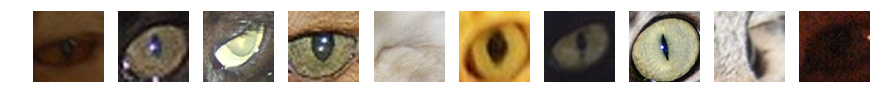

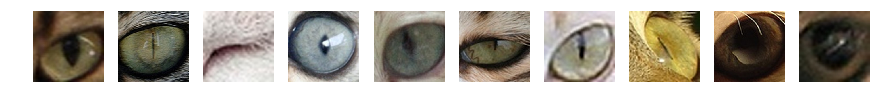


20 Imgs from cluster 1


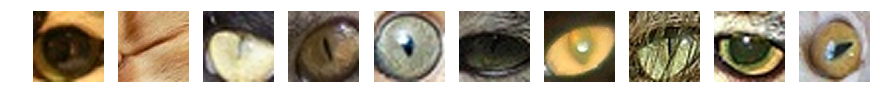

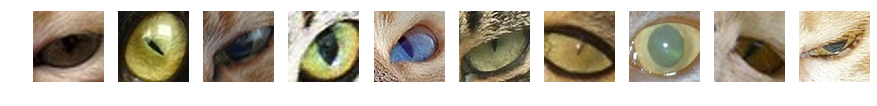


20 Imgs from cluster 2


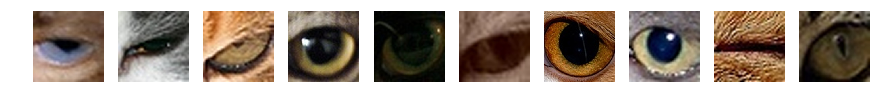

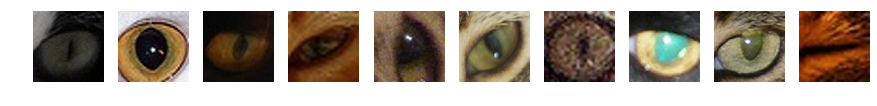


20 Imgs from cluster 3


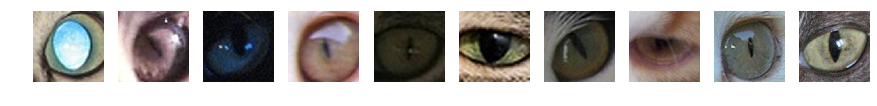

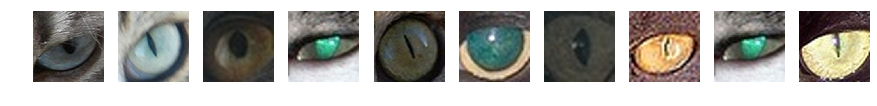


20 Imgs from cluster 4


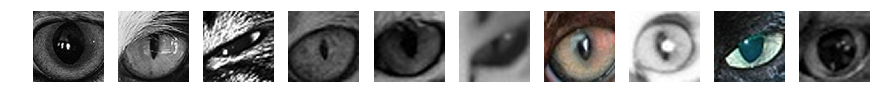

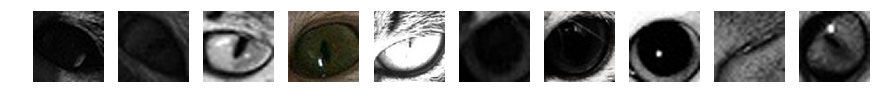


20 Imgs from cluster 5


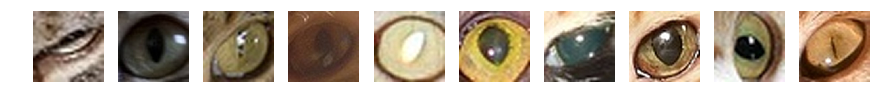

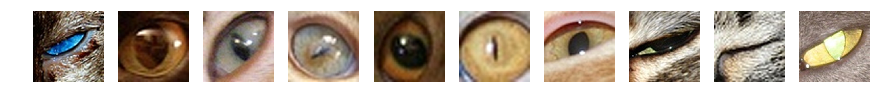

In [25]:
for i in range(kmeans.n_clusters):
    print(f'20 Imgs from cluster {i}')
    plot_array(20,clusters[i])
    print('='*100)
    print()

# T-SNE Function to visualize any possibilty of Unsupervised Clustering.

In [27]:
def create_tsne_plot(X, y, image_dirs, transform=True,
                     figsize=(45, 45), image_zoom=1, n_iter=5000,
                     perplexity=30, filename='tsne', verbose=2, color=False):

    if transform:
        svd = TruncatedSVD(n_components=100)
        X = svd.fit_transform(X)
    X_tsne = TSNE(learning_rate=100, verbose=verbose, perplexity=perplexity,
                  n_iter=n_iter).fit_transform(X)
    plt.figure(figsize=figsize)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    plt.savefig(filename + '-without-image-' + str(n_iter)+'-' +
                str(perplexity) + '.png')

    cdir = os.getcwd()
    images = []
    for x in image_dirs:
        image = cv2.imread(str(x), cv2.IMREAD_COLOR)
        if not color:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = cv2.resize(gray, (40, 30), interpolation=cv2.INTER_AREA)
        #gray = cv2.equalizeHist(gray)
        images.append(gray)
    images = np.asarray(images)
    X_tsne = StandardScaler().fit_transform(X_tsne)
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_tsne, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom, cmap='gray')
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_tsne)
    ax.autoscale()
    plt.savefig(filename + '-with-image-' + str(n_iter)+'-' + str(perplexity) +
                '.png')
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5782 samples in 0.023s...
[t-SNE] Computed neighbors for 5782 samples in 2.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5782
[t-SNE] Computed conditional probabilities for sample 2000 / 5782
[t-SNE] Computed conditional probabilities for sample 3000 / 5782
[t-SNE] Computed conditional probabilities for sample 4000 / 5782
[t-SNE] Computed conditional probabilities for sample 5000 / 5782
[t-SNE] Computed conditional probabilities for sample 5782 / 5782
[t-SNE] Mean sigma: 5265.258208
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.258415
[t-SNE] KL divergence after 5000 iterations: 1.305588


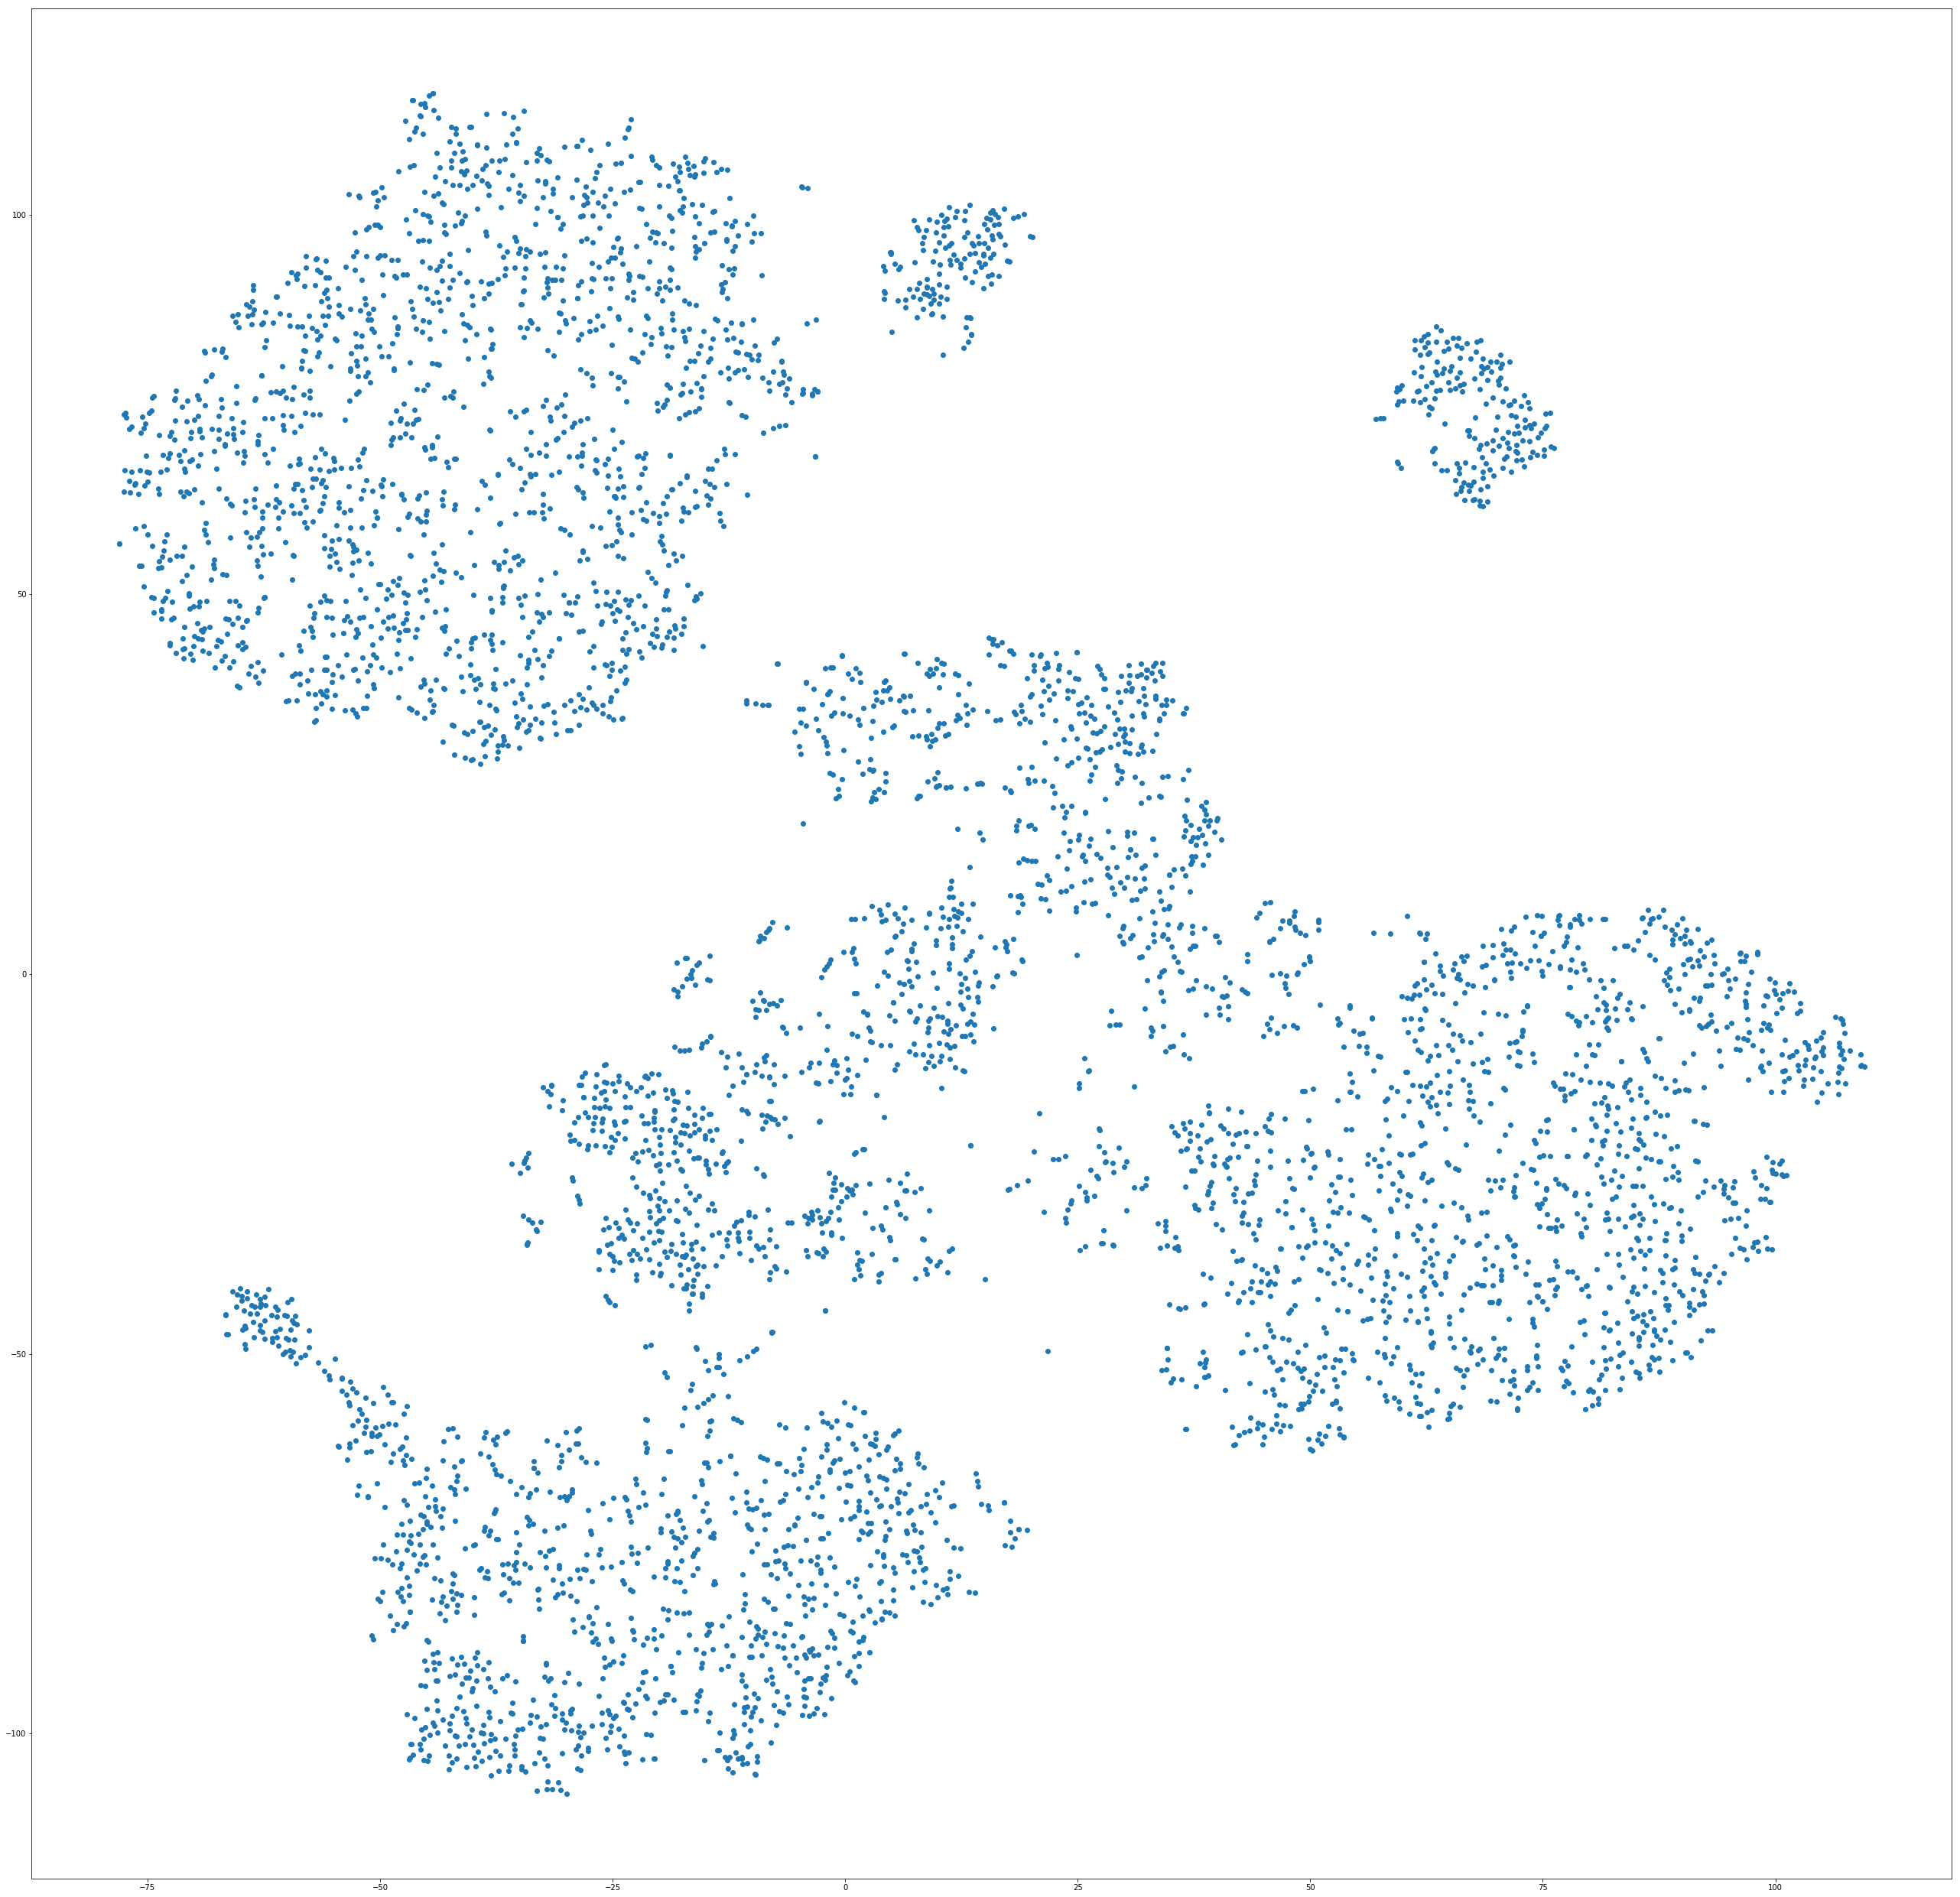

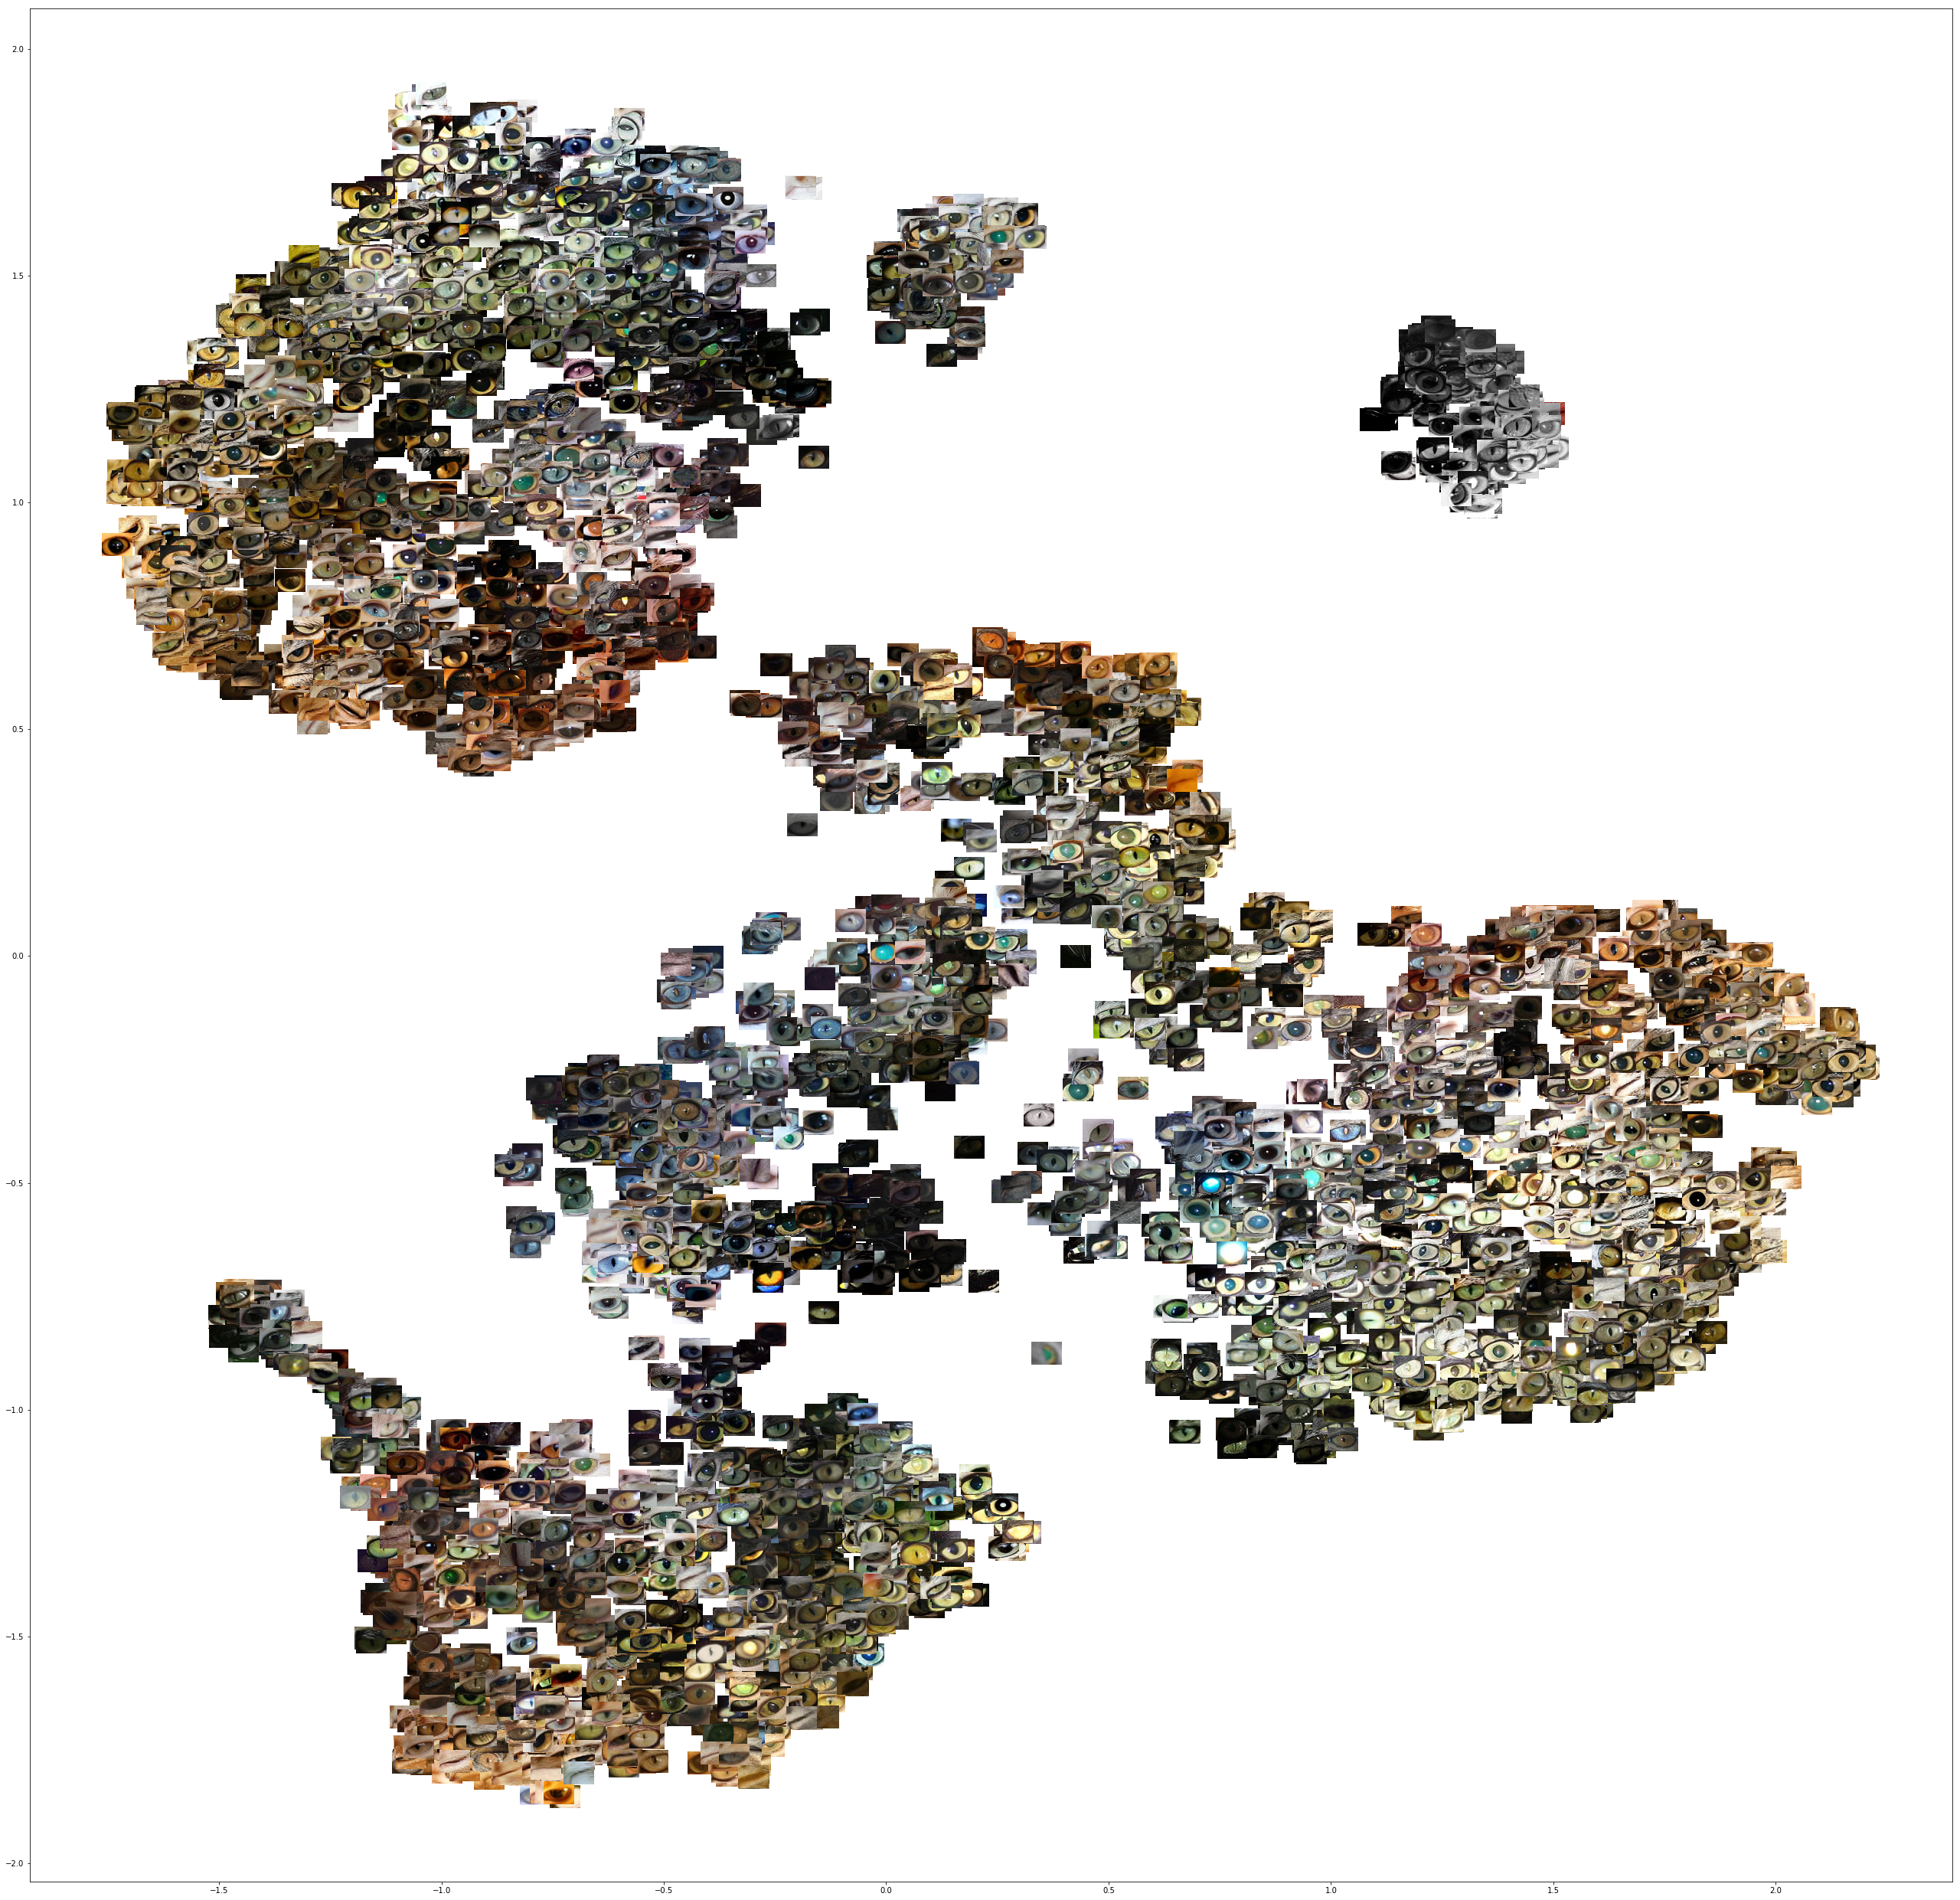

In [28]:
create_tsne_plot(histograms_hsv,1,eye_files,color=True, verbose=1)